In [5]:
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import *
import numpy as np

### Define variables

In [2]:
DATA_PATH = settings.data_path
DATE_FORMAT = '%Y-%m-%d'
START_DATE = '2016-12-21'
END_DATE = '2021-04-20'
MASK_PATH = "water_mask.json"

### Make instance of data generator

In [3]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH)

### Load sample day

In [3]:
sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

### Load water mask

In [4]:
mask_height, mask_width, _ = sample_day.rgb.shape
mask = Mask(MASK_PATH, mask_width, mask_height)

### Display mask in sample day

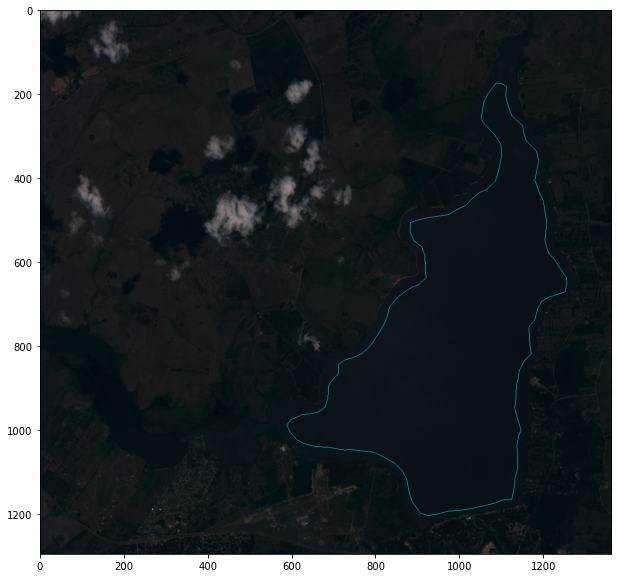

In [5]:
fig = plt.figure(figsize=(20,10))
plt.imshow(mask.display_mask_contour(sample_day.rgb))
plt.show()

### Tag valid and invalid data

In [22]:
from IPython.display import clear_output
import time

for day in data_generator:
    print(day.date)
    print(day.metadata)
    current_metadata = day.metadata
    if current_metadata != {}:
        time.sleep(0.1)
        clear_output(wait=True)
        continue
    # display rgb of day
    fig = plt.figure(figsize=(20,10))
    plt.imshow(mask.display_mask_contour(day.rgb))
    plt.show()
    # get user input
    user_input = input()
    # process input
    if user_input == "y":
        status = True
    elif user_input == "n":
        status = False
    else:
        status = "N/A"
    # overwrite with changes
    with open(day.metadata_path, 'w') as fp:
        current_metadata["valid"] = status
        json.dump(current_metadata, fp)
    clear_output(wait=True)

2021-03-26 13:42:09
{'valid': False}


### Check sizes of data

In [7]:
from collections import Counter

pbar = tqdm(total=len(data_generator))
arr_sizes = []
for day in data_generator:
    arr_sizes.append(day.get_NDCI().shape)
    pbar.update(1)

print(Counter(arr_sizes).keys()) # equals to list(set(words))
print(Counter(arr_sizes).values()) # counts the elements' frequency

 86%|████████▌ | 254/297 [02:55<00:32,  1.31it/s]

dict_keys([(1296, 1362)])
dict_values([254])


## Clustering

### Make NDCI numpy array dataset

In [5]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, DATA_PATH, skip_invalid=True)
# get count of valid days
valid_days_count = data_generator.get_valid_days_count()
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], valid_days_count+1))
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=valid_days_count+1)
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)

  0%|          | 0/76 [00:00<?, ?it/s]

Valid days: 75


100%|██████████| 76/76 [00:23<00:00,  6.31it/s]

### Make clustering dataset

In [ ]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 255:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)

### Save to json

In [16]:
json_dictionary = {}
json_dictionary["data"] = clustering_dataset
json_dictionary["positions"] = indexes
json_dictionary["dates"] = dates_list

with open("clustering_dataset.json", 'w') as f:
    json.dump(json_dictionary, f)

### Load clustering dataset

In [1]:
import json

with open("clustering_dataset.json") as f:
    clustering_data = json.load(f)

### Fit clustering data

In [3]:
from sklearn.cluster import KMeans
import numpy as np

X = clustering_data["data"]
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

### Display clusters

 95%|█████████▌| 273248/287559 [00:00<00:00, 394949.26it/s]

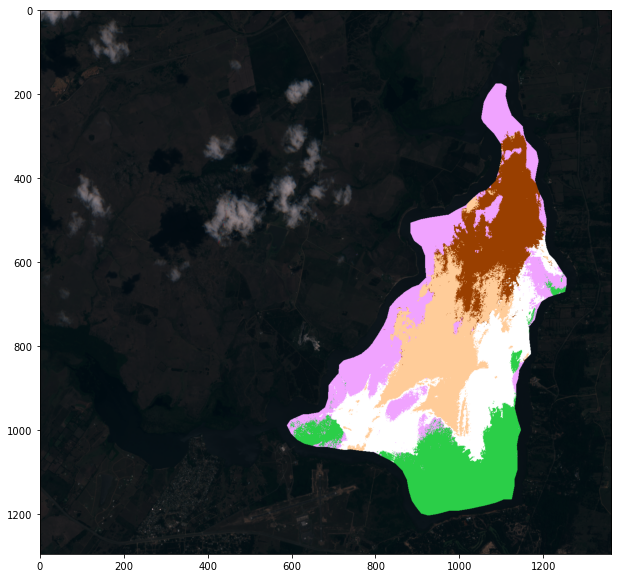

100%|██████████| 287559/287559 [00:19<00:00, 394949.26it/s]

In [11]:
sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
final_img = sample_day.rgb.copy()
clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153]]

pbar = tqdm(total=len(kmeans.labels_))
for i, label in enumerate(kmeans.labels_):
    label_position = clustering_data["positions"][i]
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]
    pbar.update(1)
    
fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
plt.show()